In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [3]:
path = "/Users/rcalef/sandbox/courses/data_vis_6.C85/a3/"

data_path = os.path.join(path, "census2000.csv")

In [4]:
def calc_quantiles(x, w, qs):
    qs = np.array(qs)
    tot = np.sum(w)
    threshs = tot * qs

    curr = 0
    curr_tot = 0
    prev_age = 0
    prev_tot = 0
    ret = []
    for age, pop in zip(x, w):
        curr_tot += pop
        if curr_tot >= threshs[curr]:
            interp = ((threshs[curr] - prev_tot) / (curr_tot - prev_tot)) * (age - prev_age)
            ret.append(interp+prev_age)
            curr += 1
            if curr == len(threshs):
                break
        prev_age = age
        prev_tot = curr_tot
    return ret

In [5]:
df = (pd.read_csv(data_path)
      .assign(
          Sex=lambda x: np.where(x.Sex == 1,
                                 "Male",
                                 "Female"),
      ))
df.head()

,Sex,Year,Age,People
0,Male,1900,0,4619544
1,Male,2000,0,9735380
2,Male,1900,5,4465783
3,Male,2000,5,10552146
4,Male,1900,10,4057669


In [6]:
df_1900 = (pd.pivot(df
                   .query("Year == 1900")
                   .drop(columns=["Year"]),
                   columns="Sex",
                   index="Age")
          .assign(tot=lambda x: x.sum(axis=1))
          .reset_index()
       )
df_1900.head()

Age   People               tot
Sex       Female     Male         
0     0  4589196  4619544  9208740
1     5  4390483  4465783  8856266
2    10  4001749  4057669  8059418
3    15  3801743  3774846  7576589
4    20  3751061  3694038  7445099

In [7]:
qs = np.linspace(0.1, 0.9, num=9)
qs

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [14]:
qs_1900 = calc_quantiles(df_1900.Age+5, df_1900.tot, qs)
qs_1900

[4.140784787060988,
 8.412174047166154,
 12.986468936094395,
 17.890947628279694,
 22.97537850067541,
 28.48026168031327,
 35.0284934418924,
 43.13292907244325,
 54.218608564008484]

In [15]:
df_2000 = (pd.pivot(df
                   .query("Year == 2000")
                   .drop(columns=["Year"]),
                   columns="Sex",
                   index="Age")
          .assign(tot=lambda x: x.sum(axis=1))
            .reset_index()
            )
df_2000.head()

Age    People                 tot
Sex        Female      Male          
0     0   9310714   9735380  19046094
1     5  10069564  10552146  20621710
2    10  10022524  10563233  20585757
3    15   9692669  10237419  19930088
4    20   9324244   9731315  19055559

In [16]:
qs_2000 = calc_quantiles(df_2000.Age+5, df_2000.tot, qs)
qs_2000

[7.20543730369596,
 14.035882527905096,
 21.113209562626846,
 28.475096151840653,
 35.42576912753757,
 41.53432205860625,
 48.05466701383352,
 56.07217135575677,
 68.6931662757967]

In [17]:
qs_df = pd.DataFrame({
    "q": qs,
    "q_1900": qs_1900,
    "q_2000": qs_2000,
})
qs_df

,q,q_1900,q_2000
0,0.1,4.140785,7.205437
1,0.2,8.412174,14.035883
2,0.3,12.986469,21.113210
3,0.4,17.890948,28.475096
4,0.5,22.975379,35.425769
5,0.6,28.480262,41.534322
6,0.7,35.028493,48.054667
7,0.8,43.132929,56.072171
8,0.9,54.218609,68.693166


In [30]:
df_2000.tail()

Age   People               tot
Sex       Female     Male         
14   70  5184855  3792145  8977000
15   75  4355644  2912655  7268299
16   80  3221898  1902638  5124536
17   85  1981156   970357  2951513
18   90  1064581   336303  1400884

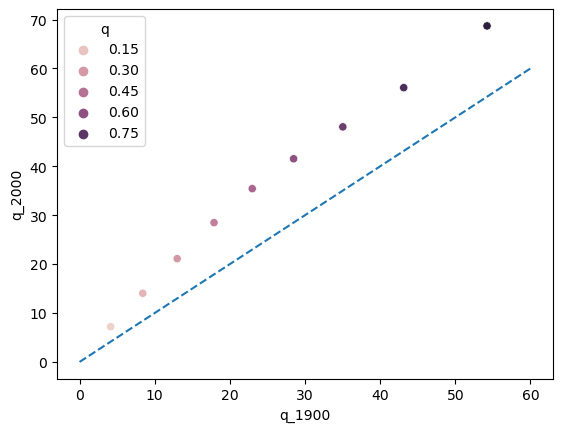

In [18]:
sns.scatterplot(x="q_1900", y="q_2000", hue="q", data = qs_df)
plt.plot([0, 60], [0, 60], '--')

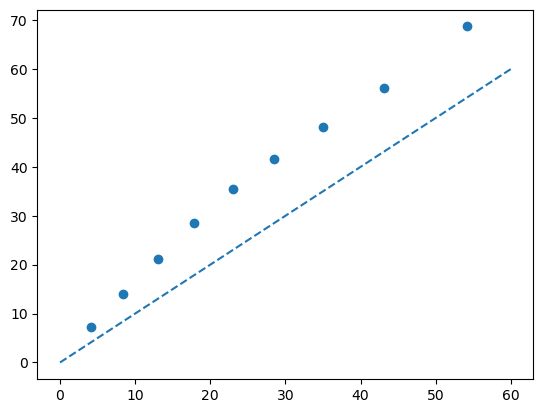

In [19]:
plt.scatter(qs_1900, qs_2000)
plt.plot([0, 60], [0, 60], '--')


In [21]:
qs_df.query("q == 0.5")

,q,q_1900,q_2000
4,0.5,22.975379,35.425769


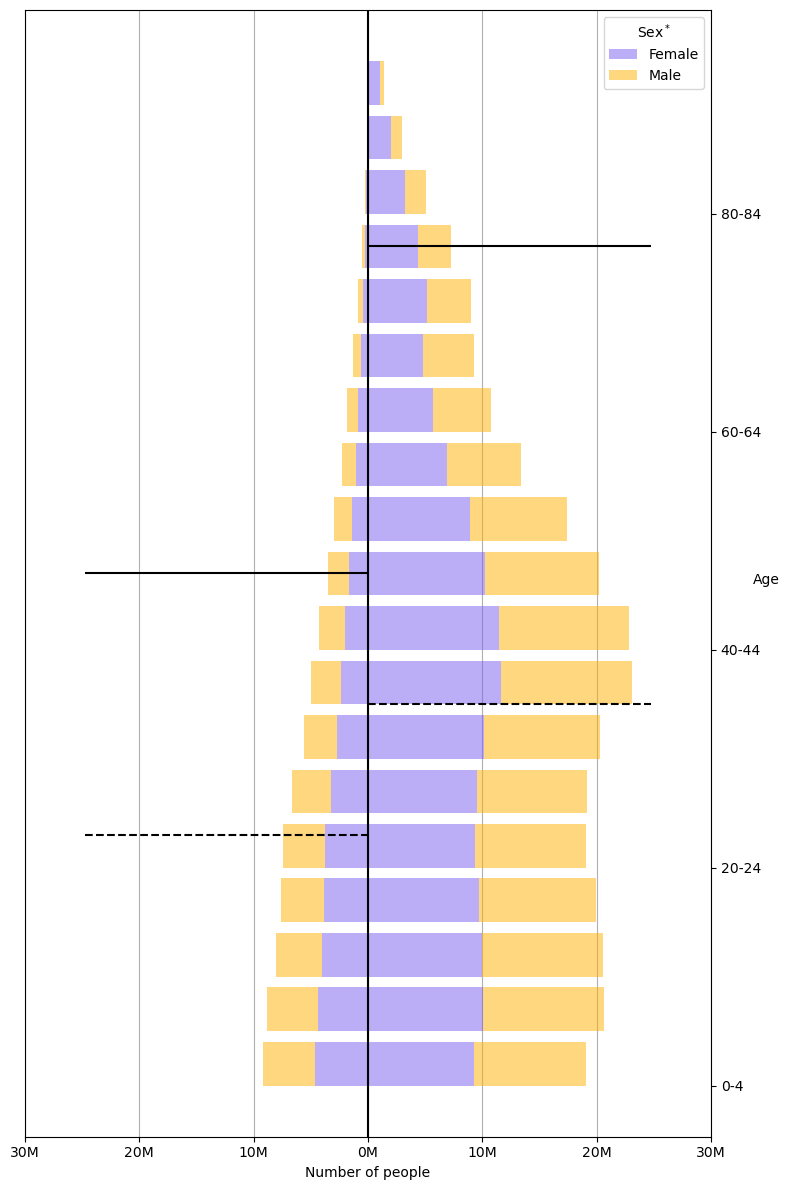

In [34]:
fig = plt.figure(figsize=(8, 12))
ax = plt.gca()

sexes = ["Female", "Male"]
buff = 0
left = np.zeros(len(df_1900)) + buff
right = np.zeros(len(df_2000)) - buff
artists = []
for sex in sexes:
    color = "#FFB000" if sex == 'Male' else "#785EF0"
    ax.barh(y=df_2000.Age+2, width=df_2000.People[sex], height=4, left=left, color=color, alpha=0.5)
#    ax.barh(y=df_2000.Age+2, width=df_2000.People[sex], height=4, left=left, color=color, alpha=0.5, hatch=".")

    left += df_2000.People[sex]

    artist = ax.barh(y=df_1900.Age+2, width=df_1900.People[sex], height=4, left=right-df_1900.People[sex], color=color, alpha=0.5)
    artists.append(artist)
    right -= df_1900.People[sex]

plt.legend(artists, sexes, title="Sex$^*$")
plt.axvline(x=0, color="black")

xmin, xmax = plt.xlim()
plt.xlim(-xmax, xmax)


locs, labels = plt.xticks()
labels = [f"{abs(int(l.get_position()[0]/1e6))}M" for l in labels]
plt.xticks(locs, labels)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

locs, labels = plt.yticks()
pos = [int(l.get_position()[1]) for l in labels]
labels = ["90+" if p == 90 else f"{p}-{p+4}" for p in pos]

plt.yticks(locs, labels)


plt.hlines(y=[23, 35], xmin=[-xmax, 0], xmax=[0, xmax], linestyles="dashed", colors="black")
plt.hlines(y=[47, 77], xmin=[-xmax, 0], xmax=[0, xmax], linestyles="solid", colors="black")


plt.xlabel("Number of people")
plt.ylabel("Age", rotation="horizontal")

ax.set_axisbelow(True)
plt.grid(axis="x", zorder=0)
plt.tight_layout()

plt.savefig("base_plot.jpeg",dpi=500)